# Lab 4 - Practical Rules for Training Neural Networks

In this Lab we will understand what are the main practical rules for training Neural Networks (NNs). To do so we will use PyTorch, that is one of the most  powerful and used framework for working with NNs. If you are interested, you can find the documentation here https://pytorch.org/docs/stable/index.html, it is not mandatory, but with this you can better understand some parts of the code of this lab.

In [1]:
##################################################
# Imports
##################################################

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from tqdm.notebook import tqdm
import time

# Setting the device
if torch.cuda.is_available():
    print('GPU enabled!')
    device = torch.device("cuda:0")
else:
    print('You are not using the GPU, activate it following:')
    print('"Runtime" --> "Change runtime type" --> "Hardware accelerator" --> "GPU" --> "Save"')
    device = torch.device("cpu")

# Plot setting
plt.style.use('dark_background')

GPU enabled!


In [2]:
##################################################
# Utility functions
##################################################

def show_images_as_grid(images, labels, nrow=16, num_images=None):
    """
    Args:
        images: batch of images of shape [batch_size, channels, height, width]
    """
    if num_images is not None:
        images = images[:num_images]
    image_grid = torchvision.utils.make_grid(images, nrow=nrow)
    image_grid = image_grid.numpy().transpose(1, 2, 0)
    plt.figure(figsize=(15, 7))
    plt.title('Input Samples', fontweight='bold', fontsize=15)
    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def accuracy(preds, labels):
    """
    Args:
        preds: torch tensors of shape [batch_size, num_classes]
        labels: torch tensors of shape [batch_size]
    """
    _, preds = torch.max(preds, -1)
    acc = torch.where(labels == preds, torch.ones_like(preds), torch.zeros_like(preds)).sum() / preds.shape[0]
    return acc

# CIFAR-10 Dataset

100%|██████████| 170M/170M [00:04<00:00, 37.1MB/s]


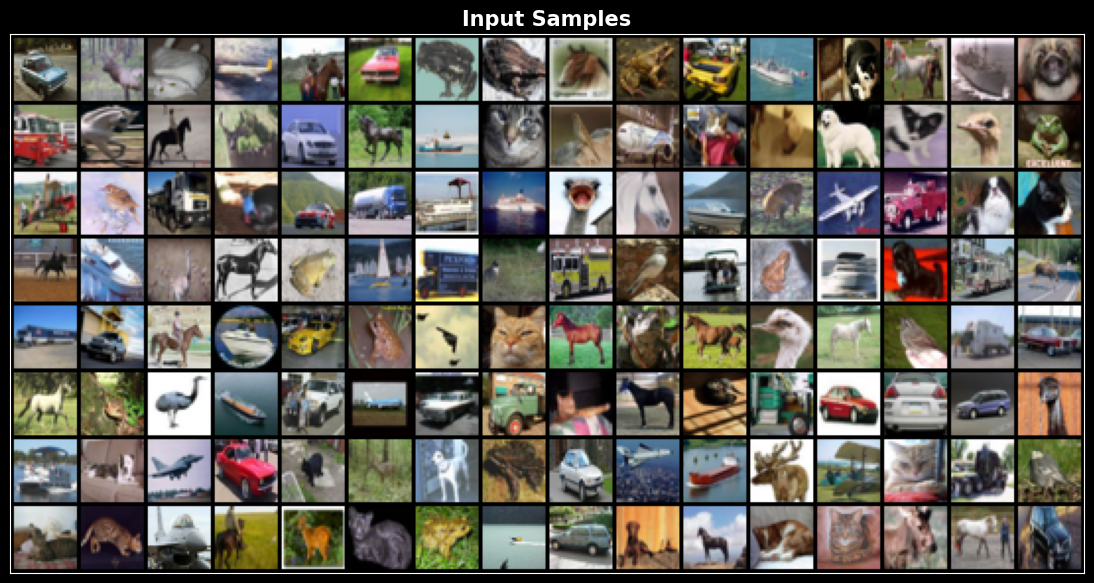


##################################################
# Dataset Info
##################################################

Name: CIFAR-10
Num Train Samples: 50000
Num Test Samples: 10000
Image shape: [3, 32, 32]
Flattened image shape: 3072
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
##################################################
# Dataset
##################################################

# Download CIFAR-10 dataset
"""
    Link to the dataset website: https://www.cs.toronto.edu/~kriz/cifar.html
"""
ds_train = torchvision.datasets.CIFAR10(root='./', train=True, transform=torchvision.transforms.ToTensor(), download=True)
ds_test = torchvision.datasets.CIFAR10(root='./', train=False, transform=torchvision.transforms.ToTensor(), download=True)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=256, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=256, shuffle=False)
in_dim = np.prod(ds_train.__getitem__(0)[0].shape)

# Show some images from MNIST
for x, y in dl_train:
    show_images_as_grid(x, y, num_images=128)
    break

# Info of the dataset
print()
print('##################################################')
print('# Dataset Info')
print('##################################################')
print()
print('Name:', 'CIFAR-10')
print('Num Train Samples:', len(ds_train))
print('Num Test Samples:', len(ds_test))
print('Image shape:', list(ds_train.__getitem__(0)[0].shape))
print('Flattened image shape:', in_dim)
print('Number of classes:', len(ds_train.classes))
print('Classes:', ds_train.classes)

# Model Creation

In [6]:
##################################################
# Model
##################################################

class MLP(nn.Module):
    """
    Our MLP torch model.

    Args:
      in_dim: input dimension
      layers_size (list): the output size of each layer in the model.
                          The last one must be equal to 10.
                          Example:
                          layers_list = [256,10] means that there is one hidden layer;
                          the output of the hidden layer has dimension 256;
                          the output of the model has dimension 10
      activation (str):  the activation fuction
      lr: the learning rate
      init_kind (str): the initialization distribution of the weights and biases
      dropout_rate: the dropout rate %%%% percentuale neuroni disattivati per layer %%%%% SIMIL-REGOLARIZZAZIONE
    """
    def __init__(self, in_dim, layers_size=[10], activation='sigmoid', lr=8e-1,
                 init_kind='zeros', dropout_rate=0.0):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.lr = lr
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = self._get_activation(activation)
        self.layers = self._get_layers(layers_size)
        self._init_weights_and_biases(init_kind)
        self._compile()

    def _get_layers(self, layers_size):
        layers = []
        in_dim = self.in_dim
        for idx_l, l_size in enumerate(layers_size):
            layers += [nn.Linear(in_dim, l_size)]
            if idx_l < len(layers_size) - 1:
                layers += [self.activation]
                layers += [self.dropout]
            in_dim = l_size
        return nn.Sequential(*layers)

    def _get_activation(self, act_kind):
        if act_kind == 'relu':
            return nn.ReLU()
        elif (act_kind is None) or (act_kind == 'linear'):
            return nn.Identity()
        elif act_kind == 'sigmoid':
            return nn.Sigmoid()
        elif act_kind == 'tanh':
            return nn.Tanh()
        else:
            raise Exception(f'Error. Activation "{act_kind}" is not supported.')

    def _compile(self, lr=1e-3):
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def _init_weights_and_biases(self, init_kind):
        for l in self.layers:
            if not (type(l) == nn.Linear):
                continue
            if init_kind == 'zeros':
                torch.nn.init.zeros_(l.weight)
            elif init_kind == 'uniform':
                torch.nn.init.uniform_(l.weight, a=-0.1, b=0.1)
            elif init_kind == 'normal':
                torch.nn.init.normal_(l.weight, mean=0.0, std=1e-3)
            elif init_kind == 'xavier':
                torch.nn.init.xavier_uniform_(l.weight)
            l.bias.data.fill_(0.00)

    def forward(self, x):
        x = self.layers(x)
        return x

# Training Procedure: Gradient Computed by PyTorch!

In [5]:
##################################################
# Training and evaluation
##################################################

def train(model, dl_train, dl_test, accuracy_fn, device, epochs=10):
    """
    Training function.
    Args:
        model: torch model.
        dl_train: torch dataloader for train. More info at: https://pytorch.org/docs/stable/data.html
        dl_test: torch dataloader for test. More info at: https://pytorch.org/docs/stable/data.html
        accuracy_fn: function used for computing the accuracy.
        device: gpu or cpu.
        epochs: number of epochs for the training.
    """
    def _forward(dl, mode):
        """
        Forward pass of the entire dataset into the model.
        Args:
            dl: torch dataloader. More info at: https://pytorch.org/docs/stable/data.html
            mode: string in ['train', 'test'].
        """
        if mode == 'train':
            model.train()
        else:
            model.eval()

        # Cache
        running_loss, running_acc = [], []
        pbar = tqdm(desc='Training' if mode == 'train' else 'Test',
                    total=len(dl.dataset))

        # Loop over the dataset
        for x, y in dl:

            # CPU -> GPU
            x = x.to(device)
            y = y.to(device)
            batch_size = x.shape[0]

            # zero the parameter gradients
            if mode == 'train':
                model.optimizer.zero_grad()

            # Image to vector: [batch_size, 32, 32, 3] -> [batch_size, 3072]
            x = x.view(batch_size, -1)

            # Forward + backward + optimize
            logits = model(x)
            loss_batch = model.loss(logits, y)
            acc = accuracy_fn(F.softmax(logits, -1), y)
            if mode == 'train':
                loss_batch.backward()
                model.optimizer.step()

            # Cache
            running_loss += [loss_batch.item()]
            running_acc += [acc.item()]
            pbar.update(batch_size)
            pbar.set_postfix({'loss': running_loss[-1], 'acc': running_acc[-1]})
        pbar.set_postfix({'loss': np.mean(running_loss), 'acc': np.mean(running_acc)})
        pbar.close()
        return np.mean(running_loss), np.mean(running_acc)

    # Start timer
    t0 = time.time()

    # Caching useful quantities
    loss = {'train': [], 'test': []}
    accuracy = {'train': [], 'test': []}
    dls = {'train': dl_train, 'test': dl_test}

    # Loop over the epochs
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1:03d}/{epochs:03d}')

        for mode in ['train', 'test']:
            dl = dls[mode]
            loss_epoch, acc_epoch = _forward(dl, mode)
            loss[mode] += [loss_epoch]
            accuracy[mode] += [acc_epoch]

    # Stop timer
    t1 = time.time()
    duration = t1 - t0
    return loss, accuracy, duration

# GPU vs CPU

In [ ]:
# Create a small and a bigger models on the CPU and on the GPU
small_net_cpu = MLP(in_dim, [128, 10])
bigger_net_cpu = MLP(in_dim, [4096, 4096, 2048, 10])
small_net_gpu = MLP(in_dim, [128, 10]).to(device)
bigger_net_gpu = MLP(in_dim, [4096, 4096, 2048, 10]).to(device)
print('##################################################')
print('# SMALL NET')
print('##################################################')
print(small_net_cpu)
print()
print('##################################################')
print('# BIGGER NET')
print('##################################################')
print(bigger_net_gpu)
print()

##################################################
# SMALL NET
##################################################
MLP(
  (dropout): Dropout(p=0.0, inplace=False)
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
  (loss): CrossEntropyLoss()
)

##################################################
# BIGGER NET
##################################################
MLP(
  (dropout): Dropout(p=0.0, inplace=False)
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=4096, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): Sigmoid()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=4096, out_features=2048, bias=True)
    (7): Sigmoid()
    (8): Dropout(p=0.0, inplac

In [ ]:
# Train the model on the CPU
_, _, t_small_cpu = train(small_net_cpu, dl_train, dl_test, accuracy, device='cpu', epochs=1)
_, _, t_big_cpu = train(bigger_net_cpu, dl_train, dl_test, accuracy, device='cpu', epochs=1)

# Train the model on the GPU
_, _, t_small_gpu = train(small_net_gpu, dl_train, dl_test, accuracy, device=device, epochs=1)
_, _, t_big_gpu = train(bigger_net_gpu, dl_train, dl_test, accuracy, device=device, epochs=1)

Epoch 001/001


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 001/001


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 001/001


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 001/001


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
print('TIME REQUIRED FOR SMALL NET (~400k params, 1 epoch) -> comparable')
print(f'- CPU: {t_small_cpu:.2f} [sec]')
print(f'- GPU: {t_small_gpu:.2f} [sec]')
print()
print('TIME REQUIRED FOR BIGGER NET (~38M params, 1 epoch) -> GPU x10 faster')
print(f'- CPU: {t_big_cpu:.2f} [sec]')
print(f'- GPU: {t_big_gpu:.2f} [sec]')

TIME REQUIRED FOR SMALL NET (~400k params, 1 epoch) -> comparable
- CPU: 10.12 [sec]
- GPU: 8.72 [sec]

TIME REQUIRED FOR BIGGER NET (~38M params, 1 epoch) -> GPU x10 faster
- CPU: 204.38 [sec]
- GPU: 12.81 [sec]


# Exercise: Design the Model Architecture and Find Hyper-Parameters for the Training

The default neural network, implemented by the `MLP` class, is curretly broken. The parameters are wrongly provided, and you have to understand how to set them in order to achieve a good performance on the test set. All the parameters you have to focus on are listed here:

### Parameters on the Architecture
- Number of layers
- Number of neurons for each layer
- Activation functions
- Weights initialization
- Dropout Rate (to reduce overfitting):
    - more on dropout at https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/ or https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

### Parameters on the Training Procedure
- Learning rate
- Number of epochs

You have to specify these hyper-parameters into the `get_hyper_params` function below. Remember to use the GPU provided by Colab, otherwise your training can last forever!

In [20]:
def get_hyper_params():
    """
    Define here the parameters of the architecture of the model, such as the
    layers_size, the activation. Define also the parameters related to the
    training like the learning rate, the nuber of epochs, the initialization
    for the weights and the dropout rate.
    """
    #################################
    ##### INSERT YOUR CODE HERE #####
    # Uncomment the below code and set your parameters!
    layers_size=[256,256,128,128,10]
    activation = 'tanh'
    lr = 1e-4
    epochs = 40
    init_kind = 'xavier'
    dropout_rate = 0.1
    ##### END YOUR CODE HERE ########
    #################################
    hyper_params = {
        'layers_size': layers_size,
        'activation': activation,
        'lr': lr,
        'epochs': epochs,
        'init_kind': init_kind,
        'dropout_rate': dropout_rate,
    }
    return hyper_params

# Create the model
hyper_params = get_hyper_params()
model = MLP(
    in_dim=in_dim,
    layers_size=hyper_params['layers_size'],
    activation=hyper_params['activation'],
    lr=hyper_params['lr'],
    init_kind=hyper_params['init_kind'],
    dropout_rate=hyper_params['dropout_rate'],
).to(device)

# See model architecture
print(model)

MLP(
  (dropout): Dropout(p=0.1, inplace=False)
  (activation): Tanh()
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): Tanh()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=128, out_features=10, bias=True)
  )
  (loss): CrossEntropyLoss()
)


In [21]:
# Train the model
loss, acc, _ = train(model, dl_train, dl_test, accuracy, device=device, epochs=hyper_params['epochs'])

Epoch 001/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 002/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 003/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 004/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 005/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 006/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 007/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 008/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 009/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 010/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 011/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 012/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 013/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 014/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 015/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 016/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 017/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 018/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 019/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 020/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 021/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 022/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 023/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 024/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 025/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 026/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 027/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 028/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 029/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 030/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 031/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 032/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 033/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 034/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 035/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 036/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 037/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 038/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 039/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 040/040


Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Test:   0%|          | 0/10000 [00:00<?, ?it/s]

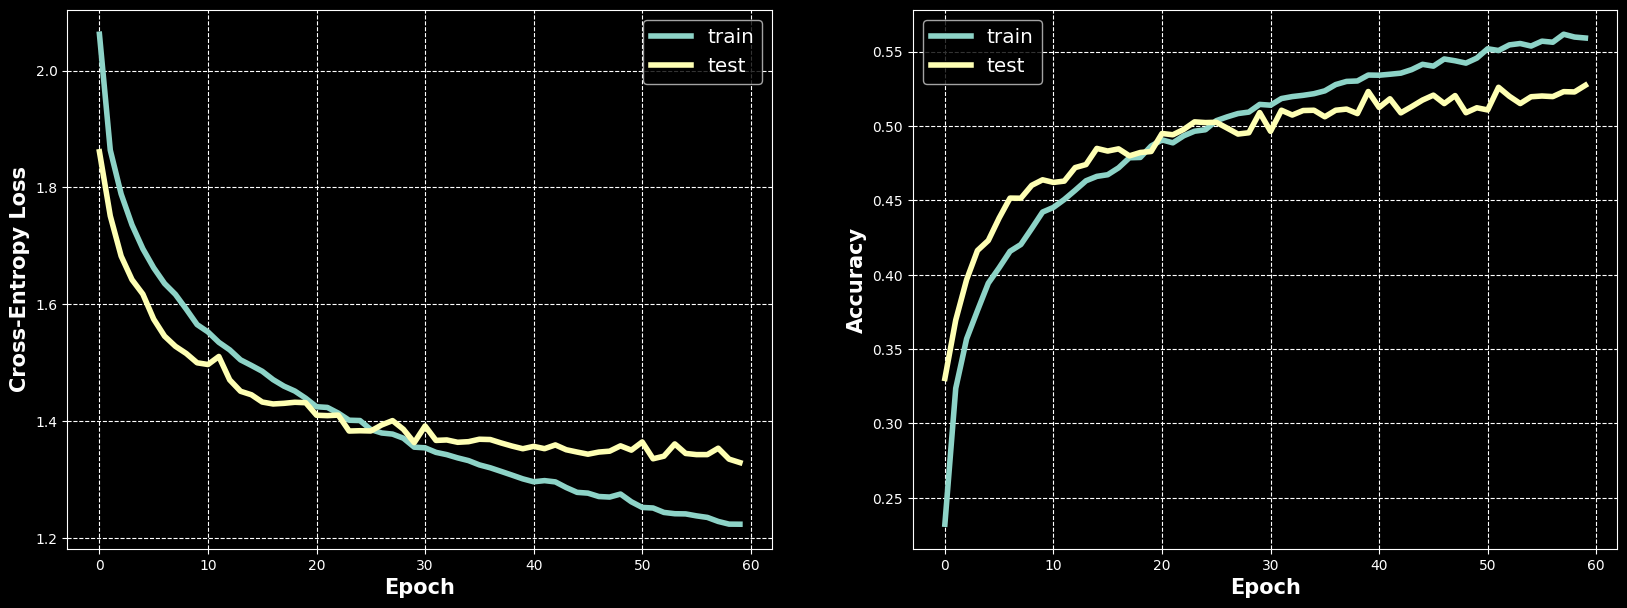

In [19]:
# Plots realted to the training
plt.figure(figsize=(20, 7))

# Plot loss
plt.subplot(1, 2, 1)
for mode in ['train', 'test']:
    plt.plot(loss[mode], lw=4, zorder=5, label=mode)
plt.grid(True, zorder=0, ls='--')
plt.ylabel('Cross-Entropy Loss', fontweight='bold', fontsize=15)
plt.xlabel('Epoch', fontweight='bold', fontsize=15)
plt.legend(fontsize='x-large')
# Plot accuracy
plt.subplot(1, 2, 2)
for mode in ['train', 'test']:
    plt.plot(acc[mode], lw=4, zorder=5, label=mode)
plt.grid(True, zorder=0, ls='--')
plt.ylabel('Accuracy', fontweight='bold', fontsize=15)
plt.xlabel('Epoch', fontweight='bold', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()
